In [1]:
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
from typing import Callable
import numpy.typing as npt

import numpy as np
from typing import Any
# from throughput import read_graph_data, read_traffic_mat, solve_problem_with_flow
from pathlib import Path
import matplotlib.pyplot as plt
from copy import  copy

from paper_code.altorithm import gamma_for_budget
from paper_code.multicommodity_flow.process_graph import read_graph, read_traffic
from paper_code.multicommodity_flow.graph_functions import GraphFunc
from paper_code.utils.drawer import get_fig_set_style, save_figures

np.random.seed(0)

In [2]:
from copy import deepcopy

p = Path('./datasets/germany50')

gr = read_graph(p)
b_max = gr['bandwidth']

# m -- number of scenarios
# n -- the dimension of the optimization space
m = 10
n = len(b_max)

# for the experiment, we determine the cost of a unit 
# of flow at the beginning of the period c_a and during the period c_b

gr['cost'] /= 100
cost = gr['cost']  ##cost of servicing a unit of flow / base cost to generate c_a and c_b

# c_b
begin_cost = ((1/cost)**0.5) * 1000 * (0.9 + np.random.rand(n) * 0.2)

# c_a
additional_cost = begin_cost * (1.05 + np.random.rand(n) * 0.1)

The costs generated based on costs of bandwidths. Based on them, the initial *rental* cost and the cost of *rent* within the period were generated. If the bandwidth is cheaper, then it is a better bandwidth, so the cost of such a bandwidth should be higher. We also consider renting more expensive than maintenance. Therefore, the values at the beginning of the period were generated as $(c_b)_i = (1/bandwidth_{cost})^{0.5} * 10 \xi$, where $\xi \sim U[9, 11]$. The rental price during the period is considered higher: $(c_a)_i = (c_b)_i * \xi, \sim U[1.05, 1.15]$, that is, more expensive from 5 to 15%.

Generating parameters for maximum flow:
select 5% of the most demanding flows and calculate the maximum flow for them. 

In [3]:
from paper_code.multicommodity_flow.graph_functions import \
            result_value, mccf_result, lambda2_result, flow_result

@dataclass
class result_handler:
    function: Callable
    x: npt.NDArray
    extra_x: npt.NDArray
    values: list[result_value]


results = []
verbose = True
for i in range(m):
    # correspondence matrix - what distinguishes different functions
    # after reading we do some thinning to make the task feasible
    traffic_mat = read_traffic(p / "tunnel_data" / f"Tunnel{i}.csv")
    scenario_fraction = 0.4
    traffic_mat = (2. * (np.random.rand(*traffic_mat.shape) > scenario_fraction)) * traffic_mat 
    f = GraphFunc(gr['graph'], gr['cost'], traffic_mat, additional_cost)    
    b_i = b_max * 4 * (np.random.rand(n)* 0.4 + 0.6)
# mccf
    mccf_res = mccf_result(f)
    mccf_res(b_i)
# lambda2
    lambda2_res = lambda2_result(f)
    lambda2_res(b_i)
# max flow
    flow_res = flow_result(f, quantile = 0.05)
    flow_res(b_i)
# insert to the list
    extra_bw = f.rez['extra_bandwidth'] 
    tmp_res = result_handler(function = f,
                             x = b_i,
                             extra_x=extra_bw,
                             values= [mccf_res, lambda2_res, flow_res])

    results.append(tmp_res)
    if verbose:
        st = "flow cost: {}\nbandwidth cost: {}\nextra bw cost: {}".format(
            mccf_res.value - additional_cost@ extra_bw,
            begin_cost@ b_i,
            additional_cost @ extra_bw
        )
        print(st)



/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 0.7603379953953546
bandwidth cost: 3.760352043108778
extra bw cost: 0.9395447010052496


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 0.573666191959142
bandwidth cost: 3.812911770935698
extra bw cost: 0.4946166265449047


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 0.755347029992379
bandwidth cost: 3.70197387269598
extra bw cost: 0.7791871075596191


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 0.6699720597661925
bandwidth cost: 3.696793261419004
extra bw cost: 0.796304437329679


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 0.4738602462963811
bandwidth cost: 3.767118860860255
extra bw cost: 0.19133376303628005


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 0.6621726842930711
bandwidth cost: 3.7461673506173376
extra bw cost: 0.7279496315465284


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 0.6257780808622674
bandwidth cost: 3.74629168829692
extra bw cost: 0.43043398854031445


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 0.5887759946013615
bandwidth cost: 3.7532558654489363
extra bw cost: 0.5863086635052079


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 0.6029763352264628
bandwidth cost: 3.7472335512973376
extra bw cost: 0.6928545705263911


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


flow cost: 0.589909824971532
bandwidth cost: 3.6839946063976368
extra bw cost: 0.5947821580894768


In [4]:
def test_point(x):
    """
    to compute function values in founded points
    """
    results_tmp = []
    for r in results:
        r_tmp = copy(r)
        r_tmp.values = []
        for ri in r.values:
            ri = ri.reset_copy()
            ri(x)
            r_tmp.values.append(ri)
        results_tmp.append(r_tmp)
    return results_tmp

протестируем несколько разных начальных бюджетов

In [5]:
def prepare_for_comp(results: list[result_handler]):
    """
    preparation of constants.
    For convenience, get_v2L_clip immediately returns the v/L values ​​for the given functions.
    In this regard, 1 is put into the L constants.
    """
    x_s = []
    v_s = []
    L_s = []
    clip_functions = []
    for r in results:
        x = r.x
        for r_i in r.values:
           v_i, cl_i = r_i.get_v2L_clip(begin_cost = begin_cost)
           x_s.extend([x])
           v_s.extend(v_i)
           clip_functions.extend(cl_i)
           L_s.extend([1]* len(v_i))
    return np.array(x_s), np.array(v_s), np.array(L_s), clip_functions


In [14]:
from joblib import Parallel, delayed
@dataclass
class budget_result_handler:
    budget: float
    x: npt.NDArray
    gamma: float
    values: list[result_handler]
    ratios: list[float] = None


# initialize parameters for computations
x_s, v_s, L_s, clip_functions = prepare_for_comp(results=results)

budgets_used = x_s @ begin_cost
b = np.mean(budgets_used)
budgets = np.linspace(0.1 * b, 1.6 * b, 10)


# compute gammas for different scenarios. 
# get_b for parallel computing.
def get_b(b, norm = 1): 
    """
    compute experiments for 
    """
    x, gamma = gamma_for_budget(b, begin_cost, x_s, v_s, L_s,
                                clip_functions, norm= norm, 
                                verbose = False, hint=True)
    values = test_point(x)

    tmp_res = budget_result_handler(
        budget=b,
        x = x,
        gamma=gamma,
        values= values,
        )
    return tmp_res

del_get_b = delayed(get_b)

# compute gammas for different scenarios 
# with different norms
budget_norm_res = dict()
for norm in [1, 2, "inf"]: #, 2, "inf"]:
    budget_res = Parallel(n_jobs= 7)(del_get_b(b, norm) for b in budgets)            
    budget_norm_res[norm] = budget_res


Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.


the next cell shows what is in the structure `budget_norm_res` -- result for budgets ad different norms

In [15]:
# an example of one result
func_number = 0
budget_number = 0
case_number = 0
norm_type = 1
budget_norm_res[norm_type][budget_number].values[case_number].values[func_number]

mccf_result(graph_func=<paper_code.multicommodity_flow.graph_functions.GraphFunc object at 0x32f54dac0>, value=3.5750098096418834)

plotting results for all functions

norm_type=1
    mccf:


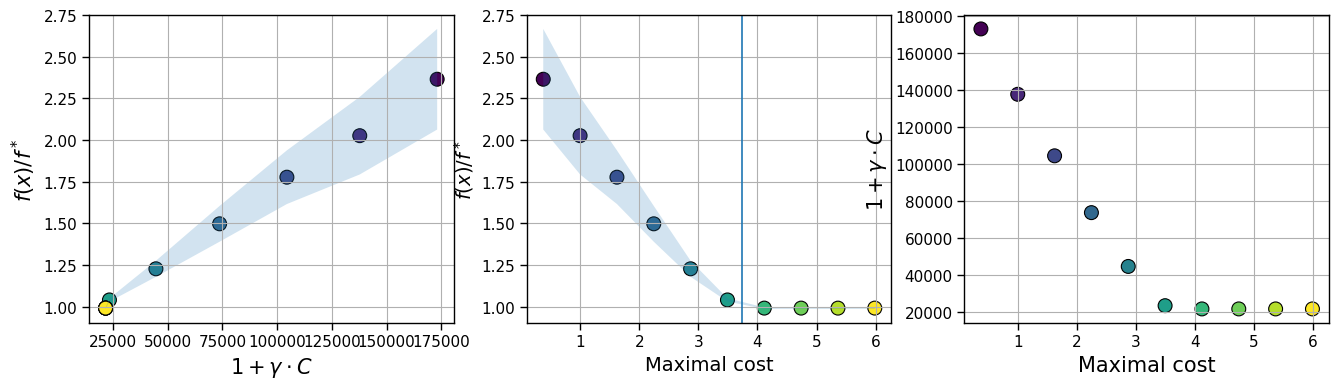

    lambda2:


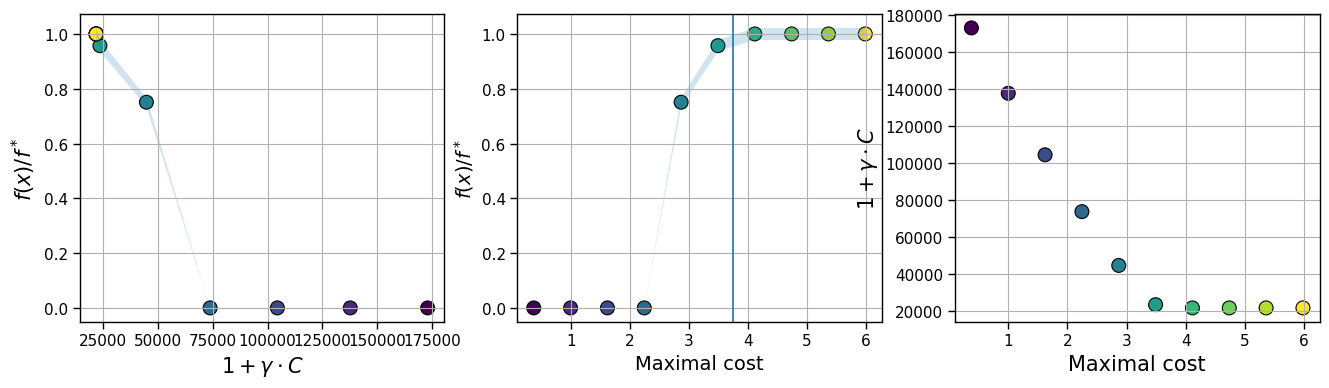

    flow:


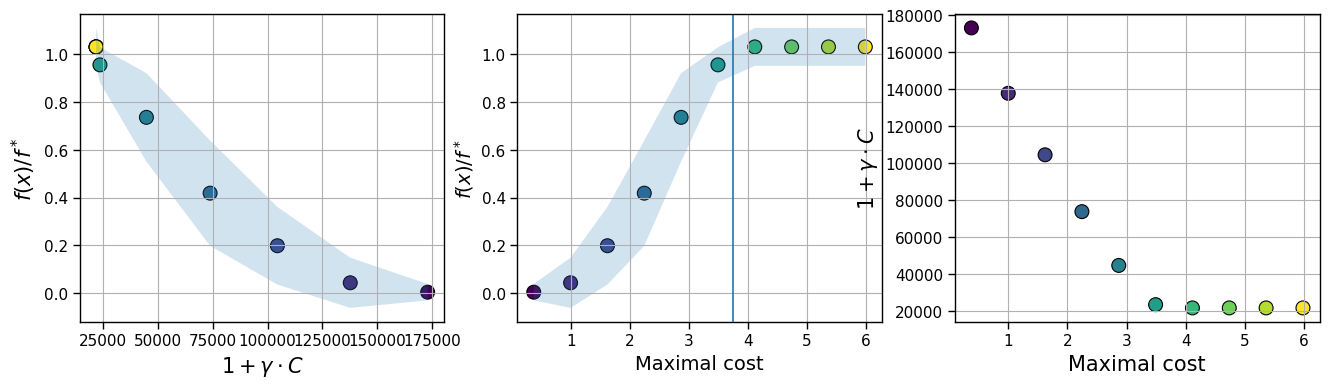

norm_type=2
    mccf:


/Users/ilgam/miniconda3/envs/paper/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


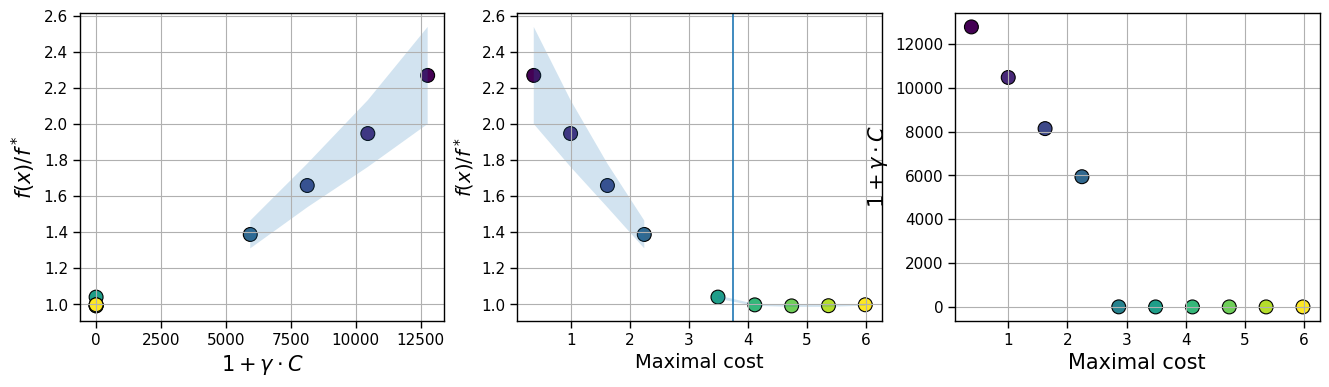

    lambda2:


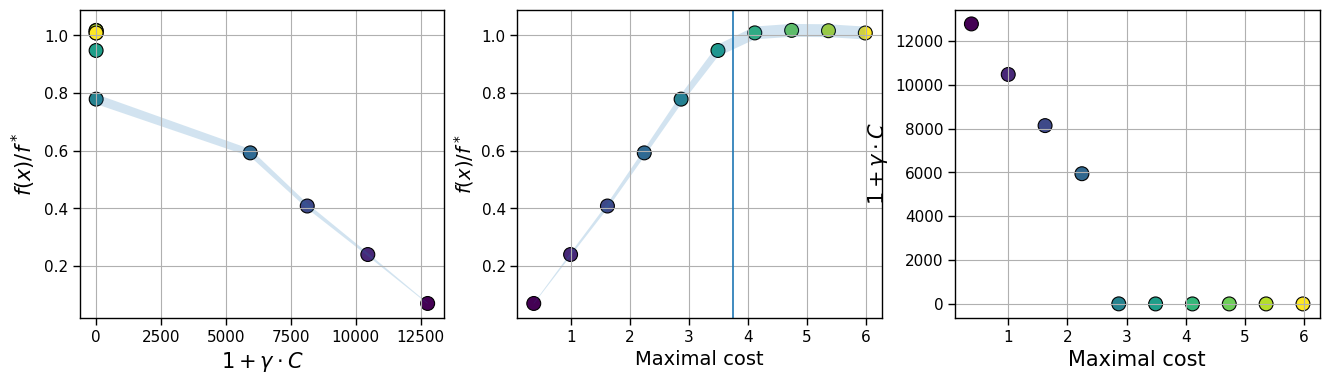

    flow:


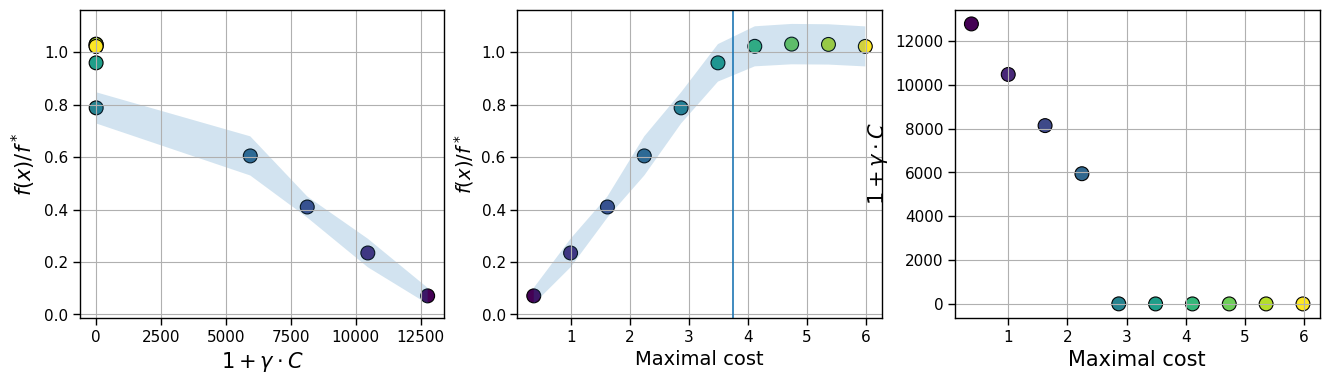

norm_type='inf'
    mccf:


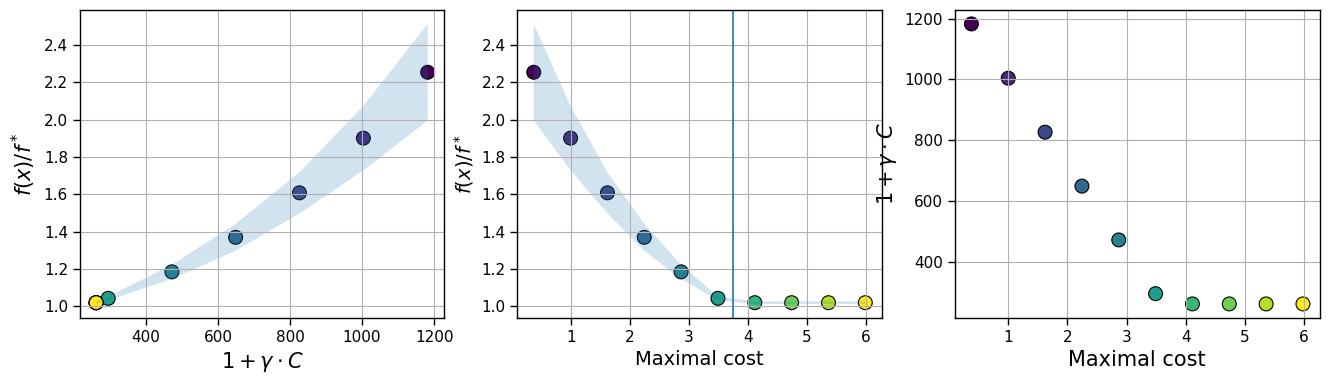

    lambda2:


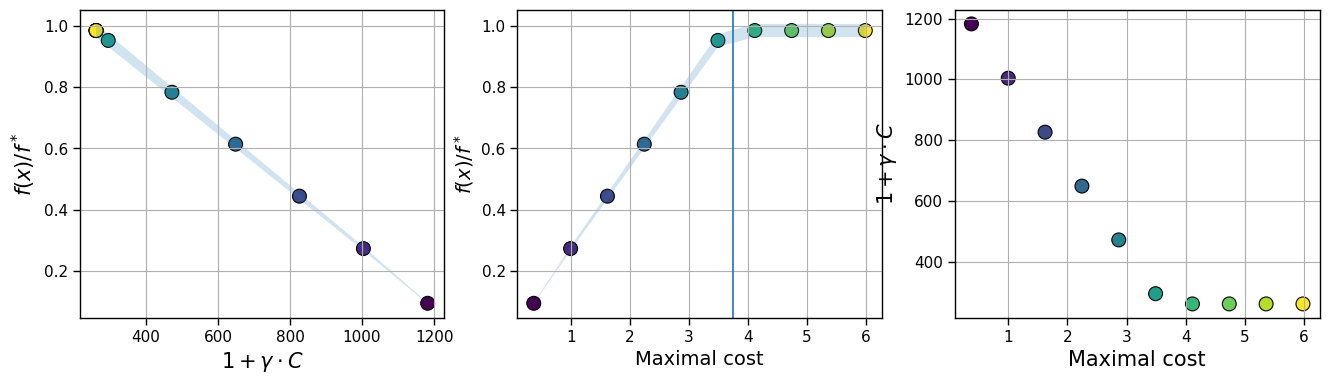

    flow:


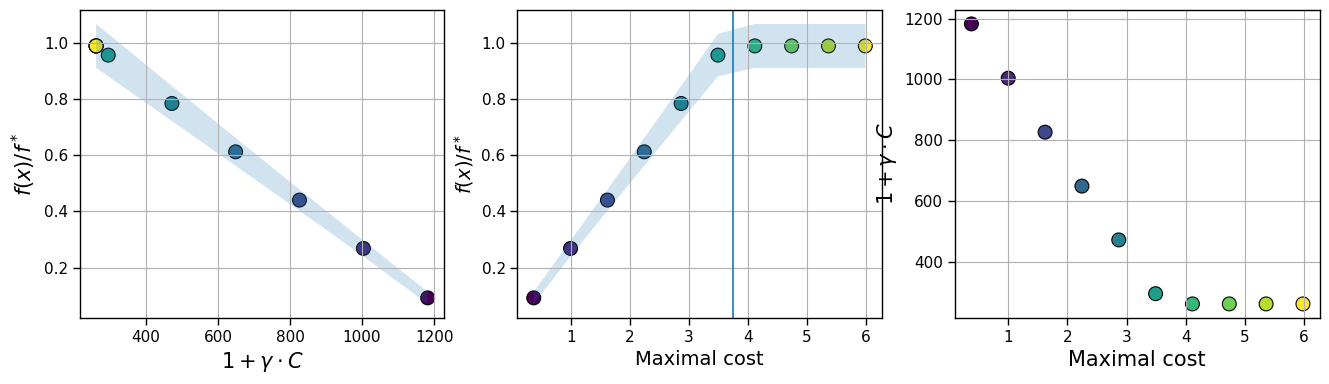

In [16]:
from paper_code.utils.drawer import plot_ratios
x1 = "Maximal cost"
y1 = r"$f(x)/f^*$"
l1 = r"$1 + \gamma \cdot C$"
for norm_type in budget_norm_res.keys():
    print(f"{norm_type=}")
    norm_res = budget_norm_res[norm_type]
    gammas = [1 + r.gamma for r in norm_res]
    for fn, name in zip(range(3), ["mccf","lambda2", "flow"]):
        # function types: mccf, lambda2, flow
        print(f"    {name}:")
        budget_case_res = [[norm_res[bn].values[cn].values[fn].value for cn in range(m)]\
                            for bn in range(len(norm_res))]
        budget_case_res = np.array(budget_case_res, dtype=float)        
        budget_case_res[np.isnan(budget_case_res)] = 0.
        case_res = np.array([results[cn].values[fn].value for cn in range(m)])[None, ...]
        ratios = budget_case_res/case_res
        # print(budget_case_res.shape, case_res.shape, ratios.shape)
        ind = tuple(range(1, len(ratios.shape)))
        ratios = np.array([ratios.mean(ind), ratios.std(ind)])
        fig, ax = plot_ratios(ratios, gammas, budgets, x1,y1,l1, ratios_procecced=True)
        ax[1].axvline(x=np.mean(budgets_used))
        plt.show()
        

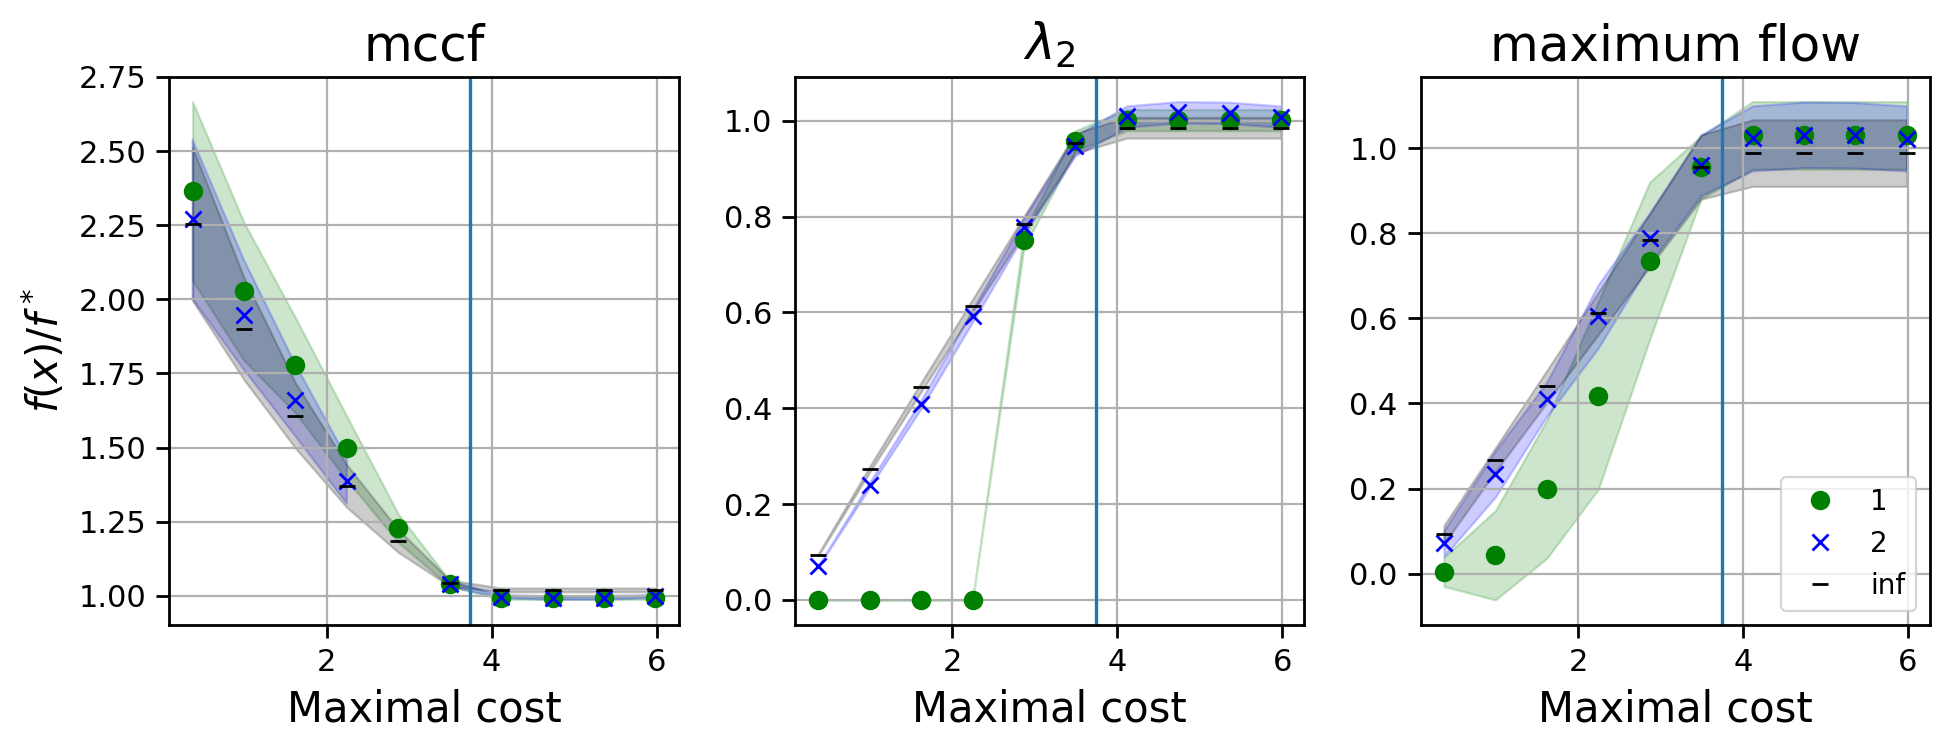

In [17]:
# import jotaviz
# from jotaviz import styles
# st = styles.Style()

# plt.style.use('jotaviz')

from paper_code.utils.drawer import plot_ratios, get_fig_set_style


x1 = "Maximal cost"
y1 = r"$f(x)/f^*$"
l1 = r"$1 + \gamma \cdot C$"

styles = ['o', 'x', '_']

fig, ax = get_fig_set_style(shape=(1,3), figsize= (10, 4))
# fig, ax = plt.subplots(*(1,3), dpi=300, figsize=(16, 5))
for fn, name in zip(range(3), ["mccf",r"$\lambda_2$", "maximum flow"]):
    ratios_all = []
    for norm_type in budget_norm_res.keys():
        norm_res = budget_norm_res[norm_type]
        gammas = [1 + r.gamma for r in norm_res]
        # function types: mccf, lambda2, flow
        budget_case_res = [[norm_res[bn].values[cn].values[fn].value for cn in range(m)]\
                            for bn in range(len(norm_res))]
        budget_case_res = np.array(budget_case_res, dtype=float)        
        budget_case_res[np.isnan(budget_case_res)] = 0.
        case_res = np.array([results[cn].values[fn].value for cn in range(m)])[None, ...]
        ratios = budget_case_res/case_res
        ind = tuple(range(1, len(ratios.shape)))
        ratios = np.array([ratios.mean(ind), ratios.std(ind)])
        ratios_all.append(ratios)
    
    # ratios_all = np.array(ratios_all)  
    # mean_ratios = ratios_all.mean(0)
    # ratios_all = (ratios_all - mean_ratios)/mean_ratios
    ax[fn].set_title(name)
    ax[fn].grid()
    ax[fn].axvline(x=np.mean(budgets_used))
    ax[fn].set_xlabel(x1)
    for i, (norm_type, color) in enumerate(zip(budget_norm_res.keys(), ['g', 'b', 'black'])):
        ax[fn].plot(budgets[:], ratios_all[i][0], styles[i], label = f"{norm_type}", color = color, markersize = 6)
        ax[fn].fill_between(budgets[:], 
                            ratios_all[i][0]-ratios_all[i][1], 
                            ratios_all[i][0]+ratios_all[i][1], alpha = 0.2, color = color)
ax[0].set_ylabel(y1)
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()

In [18]:
save_figures({"multi": fig}, Path("figures"))